# Implementing the Gradient Descent Algorithm

In this notebook, I first of all implemented the functions that build the gradient descent algorithm, namely:

* `sigmoid`: The sigmoid activation function.
* `output_formula`: The formula for the prediction sigmoid(weights*features + bias).
* `error_formula`: The formula for the error at a point.
* `update_weights`: The function that updates the weights and bias with one full gradient descent step.


After the `train` function is run, it will graph several of the lines that are drawn in successive gradient descent steps. It will also graph the error function, and we'll be able to see it decreasing as the number of epochs grows.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Import to ignore warnings
import warnings 
warnings. filterwarnings('ignore')

## Functions

In [2]:
# Some functions for plotting and drawing lines

def plot_points(X, y):
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    '''This function plots green dotted lines for the model learnt boundary after some specified epochs during training'''
    x = np.arange(-250, 1000, 100)
    plt.plot(x, m*x+b, color)

## Implementing the basic functions

- Sigmoid activation function

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

- Output (prediction) formula

$$\hat{y} = \sigma(w_1 x_1 + w_2 x_2 + b)$$

- Error function

$$Error(y, \hat{y}) = - y \log(\hat{y}) - (1-y) \log(1-\hat{y})$$

- The function that updates the weights

$$ w_i \longrightarrow w_i + \alpha (y - \hat{y}) x_i$$

$$ b \longrightarrow b + \alpha (y - \hat{y})$$

In [3]:
# Activation (sigmoid) function
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Output (prediction) formula
def output_formula(features, weights, bias):
    out = np.dot(features, weights) + bias
    return sigmoid(out)  

# Error (log-loss) formula
def error_formula(y, output):
    return -y*np.log(output)-((1-y)*np.log(1-output))
    
# Gradient descent step
def update_weights(weights, bias, weights_list, bias_list):
    weights , bias = weights+np.sum(np.array(weights_list), axis=0), bias+np.sum(np.array(bias_list))
    return weights, bias

# Calculating the value to be added to weights and bias by each datapoint
def wt_bias_increment(x, y, weights, bias, learnrate):
    weights = (learnrate*(y-output_formula(x, weights, bias))*x)
    bias = (learnrate*(y-output_formula(x, weights, bias)))
    return weights, bias
    

## Reading and plotting the data

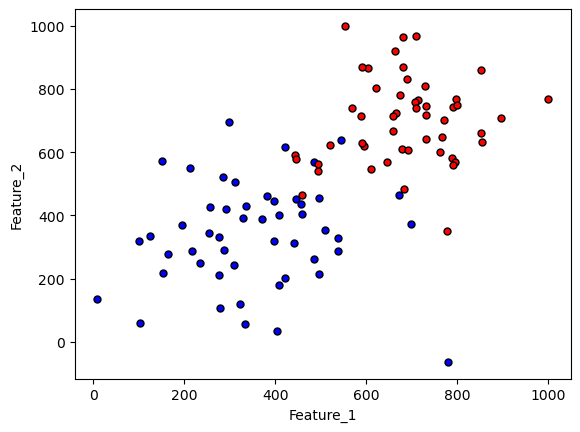

In [4]:
data = pd.read_csv('Datasets/log_reg.csv', header=None)
X = np.array(data[[0,1]])

# Scaling the features up by 1000 to make things more interesting
X= X*1000

y = np.array(data[2])
plot_points(X,y)
plt.xlabel('Feature_1')
plt.ylabel('Feature_2')
plt.show()

## Training function
This function will help us iterate the gradient descent algorithm through all the data, for a number of epochs. It will also plot the data, and some of the boundary lines obtained as we run the algorithm.

In [5]:
# Setting a random seed for reproduceability with respect to weights initialization
np.random.seed(4)

def train(features, targets, epochs, learnrate, early_stop_epochs = 100, graph_lines=False):
    # Creating a list for the errors
    errors = []
    
    # Creating lists to store weight and bias update by each datapoint after an epoch since this is full Gradient Descent
    wt_list = []
    bias_list = []   
    
    # Getting the value of the number rows and columns into variables
    n_records, n_features = features.shape
    
    # Defining a variable for the last loss value
    last_loss = None
    
    # Creating an array for the initialization of weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)
    
    # Initializing the bias
    bias = -7
    
    # Looping through Epochs
    for e in range(epochs):
        
        # Looping through each datapoint during an epoch to get their update to the weights and bias
        for x, y in zip(features, targets):
            # Calculating the sigmoid output for each row basically
            output = output_formula(x, weights, bias)
            
            # Calculating the error a row produces which is basically the log(output_probability)
            error = error_formula(y, output)
            
            # uncomment this to show the weight, bias, model learnt funtion output, update to weights and bias for 
            # each datapoint
            '''print('weight at epoch {}, bias at epoch {}, datapoint class {}, function output with datapoint {} '
                  'sigmoid output probability {}, update to weight by point {}'.format(weights, 
                    bias, y, np.dot(x, weights) + bias, sigmoid(np.dot(x, weights)+bias),
                    (learnrate*(y-sigmoid(np.dot(x, weights)+bias))*x)))'''
       
            # Calculating the weight and bias increment by a row
            wt, bi = wt_bias_increment(x, y, weights, bias, learnrate)
            
            # appending the addition to weight for row_i to a list
            wt_list.append(wt)
            
            # appending the addition to bias for row_i to a list
            bias_list.append(bi)
        
        # Updating the weight and bias after an epoch with the sum of all updates by every datapoint
        weights, bias = update_weights(weights, bias, wt_list, bias_list)
        
        # Emptying the lists that stores weight and bias addition by rows during epoch for next epoch
        wt_list = []
        bias_list = []                                                                  
                                                                                      
        # Getting the probability prediction for all datapoints based on current weights and bias 
        out = output_formula(features, weights, bias)
        
        # Loss is calculated for each datapoint i.e how close prediction probability is to actual class and total loss on
        # all datapoints is gotten as the average.
        loss = np.mean(error_formula(targets, out))
        
        # Current loss is appended for sake of making plot of epoch vs loss
        errors.append(loss)
        
        # The conditional statements below helps us display the loss and accuracy at some epochs and also implements 
        # early stopping.
        if e % (epochs / 100) == 0:
            print("\n========== Epoch", e,"==========")
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing", '\n')
            else:
                print("Train loss: ", loss)
            if e > early_stop_epochs and last_loss <= loss:
                print('EARLY STOPPING APPLIED!!')
                break
            last_loss = loss
            
            # Here, we set acceptance threshold for positive as > 0.5 of sigmoid output
            predictions = out >= 0.5
            accuracy = np.mean(predictions == targets)
            print("Accuracy: ", accuracy)
            
        # Below we choose when to display a model learnt line with two conditions. Firstly if the "graphline keyword"
        # argument allows it, secondly, after every epoch that satisfies the modulo (%) condition
        if graph_lines and e % (epochs / 100) == 0:
            # We use the display function to make the plot
            display(-weights[0]/weights[1], -bias/weights[1])
            

    # Plotting the solution boundary
    plt.title("Solution boundary")
    display(-weights[0]/weights[1], -bias/weights[1], 'black')

    # Plotting the data
    plot_points(features, targets)
    #plt.savefig('Good_Classification.jpg', dpi=500)
    plt.show()

    # Plotting the error
    plt.title("Error Plot")
    plt.xlabel('Number of epochs')
    plt.ylabel('Error')
    plt.plot(errors)
    plt.show()

## Time to train the algorithm!
When we run the function, we'll obtain the following:
- A plot of the data and some of the boundary lines obtained. The final one is in black. Notice how the lines get closer and closer to the best fit, as we go through more epochs.
- A plot of the error function. Notice how it decreases as we go through more epochs.

In [6]:
# Creating Variables for Epoch and learning rate
epochs = 500
learnrate = 0.00000051


========== Epoch 0 ==========
Train loss:  nan
Accuracy:  0.51

========== Epoch 5 ==========
Train loss:  nan
Accuracy:  0.52

========== Epoch 10 ==========
Train loss:  nan
Accuracy:  0.53

========== Epoch 15 ==========
Train loss:  nan
Accuracy:  0.58

========== Epoch 20 ==========
Train loss:  nan
Accuracy:  0.63

========== Epoch 25 ==========
Train loss:  nan
Accuracy:  0.57

========== Epoch 30 ==========
Train loss:  nan
Accuracy:  0.56

========== Epoch 35 ==========
Train loss:  nan
Accuracy:  0.56

========== Epoch 40 ==========
Train loss:  nan
Accuracy:  0.56

========== Epoch 45 ==========
Train loss:  nan
Accuracy:  0.56

========== Epoch 50 ==========
Train loss:  nan
Accuracy:  0.57

========== Epoch 55 ==========
Train loss:  nan
Accuracy:  0.58

========== Epoch 60 ==========
Train loss:  nan
Accuracy:  0.58

========== Epoch 65 ==========
Train loss:  nan
Accuracy:  0.58

========== Epoch 70 ==========
Train loss:  nan
Accuracy:  0.59

========== Epoch 75 ======

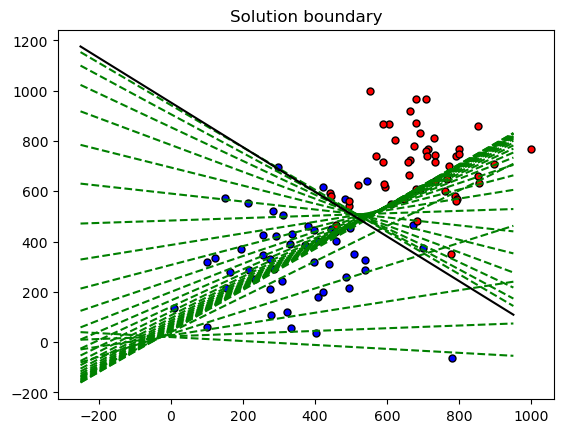

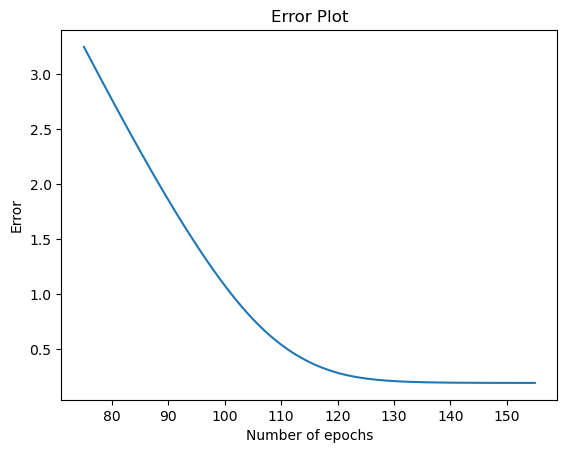

In [7]:
train(X, y, epochs, learnrate, early_stop_epochs= 50, graph_lines=True)

## SUMMARY

Scaling the features was a good way to improve my understanding of Gradient descent. I made it into full gradient descent where each datapoint use the same weight and at the end of the epoch all increments are added together and then used to update the weights and bias for better understanding.

Due to the scale of the features, the following happened;
1. The bias initialization became important.
2. The learning rate had to be very very small.
3. Early stopping was a bit necessary.

**Experiment with this notebook as much as possible, remove the scaling and see what changes. HAPPY LEARNING!!**